# Load combined data csv file

In [1]:
# pip install numpy==1.19.5  <-- needed numpy 1.19.5 to run LSTM function

In [2]:
# import all necessary libraries
import requests
import json
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
print(np.__version__)

1.19.5


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [5]:
# import FB Prophet libraries
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [6]:
# import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [7]:
# import LSTM libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

In [9]:
# this is not necessary but helps to run notebook faster
%config Completer.use_jedi = False

In [10]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [11]:
#Clear warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Set styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

In [13]:
pd.set_option("display.max_columns", 50)

In [14]:
combined = pd.read_csv('data/combined.csv')

In [15]:
# drop column 'Unnamed: 0'
combined.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
combined.shape

(26665, 28)

In [17]:
# change column 'Sale Date' to datetime
combined['sale_date'] = pd.to_datetime(combined['sale_date'], infer_datetime_format=True)

In [18]:
combined.columns

Index(['sale_date', 'item_name', 'quantity', 'transaction_id', 'listing_id',
       'ship_city', 'ship_state', 'ship_zipcode', 'ship_country', 'order_id',
       'variations', 'state', 'user_id', 'category_id', 'title', 'description',
       'tags', 'shop_section_id', 'featured_rank', 'views', 'num_favorers',
       'occasion', 'style', 'is_customizable', 'has_variations', 'taxonomy_id',
       'taxonomy_path', 'main_tag'],
      dtype='object')

# Modeling for Category 1 data

In [19]:
cat_data = combined[combined.main_tag == 'cat_1'].groupby('sale_date')['quantity'].sum()

In [20]:
cat_data = pd.DataFrame(cat_data)

In [21]:
len(cat_data)

348

Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [22]:
cat_data.sum()

quantity    3399
dtype: int64

In [23]:
dates = pd.date_range(start='2020-01-01', end='2020-12-31')
type(dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [24]:
dates = pd.DataFrame(dates)

In [25]:
dates.columns = ['sale_date']

In [26]:
cat_data = pd.merge(left=dates, right=cat_data, on='sale_date', how='left')

In [27]:
cat_data.isna().sum()

sale_date     0
quantity     18
dtype: int64

In [28]:
cat_data.sum()

quantity    3399.0
dtype: float64

In [29]:
cat_data.fillna(0, inplace=True)

In [30]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   quantity   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [31]:
cat_data.set_index('sale_date', inplace=True)

### Train test split the data

In [32]:
cat_data_train = cat_data[:round(len(cat_data) * 0.8)]
cat_data_test = cat_data[round(len(cat_data) * 0.8):]
cat_data_test.shape

(73, 1)

### Load external data

In [33]:
cat_API = pd.read_csv('data/party_decorations_API.csv')

In [34]:
cat_API.shape

(366, 6)

In [35]:
# change column 'Sale Date' to datetime
cat_API['date'] = pd.to_datetime(cat_API['date'], infer_datetime_format=True)

In [36]:
cat_API.head()

,date,unscaled,monthly,isPartial,scale,cat
0,2020-01-01,36,0.0,0,0.00,0.00
1,2020-01-02,100,0.0,0,0.00,0.00
2,2020-01-03,78,0.0,0,0.00,0.00
3,2020-01-04,87,0.0,0,0.00,0.00
4,2020-01-05,54,82.0,False,0.82,44.28


Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [37]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [38]:
dates.head()

,sale_date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05


In [39]:
cat_API = pd.merge(left=dates, right=cat_API, left_on='sale_date', right_on='date', how='left')

In [40]:
cat_API.isna().sum()

sale_date    0
date         0
unscaled     0
monthly      0
isPartial    0
scale        0
cat          0
dtype: int64

In [41]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [42]:
cat_API.fillna(0, inplace=True)

In [43]:
cat_API.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   date       366 non-null    datetime64[ns]
 2   unscaled   366 non-null    int64         
 3   monthly    366 non-null    float64       
 4   isPartial  366 non-null    object        
 5   scale      366 non-null    float64       
 6   cat        366 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 22.9+ KB


In [44]:
cat_API.set_index('date', inplace=True)  # was 'sale_date'

### Train test split the external data

In [45]:
cat_API_train = cat_API[:round(len(cat_API) * 0.8)]
cat_API_test = cat_API[round(len(cat_API) * 0.8):]
cat_API_test.shape

(73, 6)

## FB Prophet model

In [46]:
# let's calculate the maximum amount in any category bought in one day. Plus 25 as a buffer. We'll need this 
# later to establish cap and floor in logistic Prophet
max_cap = combined.groupby(['main_tag', 'sale_date'])['quantity'].sum().max() + 25
max_cap

100

### Rename the columns

In [47]:
cat_data.reset_index(inplace=True)

In [48]:
# Prophet needs the date column to be named 'ds' and the target column to be named 'y' for it to run
cat_proph = cat_data.rename(columns={'sale_date': 'ds',
                                         'quantity': 'y'})
cat_proph.tail()

,ds,y
361,2020-12-27,2.0
362,2020-12-28,1.0
363,2020-12-29,2.0
364,2020-12-30,2.0
365,2020-12-31,3.0


In [49]:
# We need to specify a carrying capacity in order to utilize a saturating minimum later
cat_proph['cap'] = max_cap

# Let's specify a saturating minimum, so our model doesn't predict below it.
cat_proph['floor'] = 0

### Train test split the data

In [50]:
cat_proph_train = cat_proph[:round(len(cat_data) * 0.8)]
cat_proph_test = cat_proph[round(len(cat_data) * 0.8):]
cat_proph_test.shape

(73, 4)

## LSTM model

In [51]:
# function to create LSTM dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back): # was: for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Create LSTM dataset and scale it

In [52]:
# reset index in case index is equal to 'sale_date' column
cat_data.reset_index(inplace=True)

In [53]:
# drop column 'index' if it exists
cat_data.drop('index', axis=1, inplace=True)

In [54]:
cat_lstm = cat_data
cat_lstm.set_index('sale_date', inplace=True)

In [55]:
cat_lstm.head()

,quantity
sale_date,
2020-01-01,4.0
2020-01-02,7.0
2020-01-03,5.0
2020-01-04,15.0
2020-01-05,8.0


In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(cat_lstm)

## Evaluation

In [57]:
# imput RMSE values from pther notebooks
arima_rmse = 4.241642913750046
sarimax_rmse = 3.36

log_proph_train_rmse_weekly = 4.34
log_proph_train_rmse = 4.29
log_proph_train_rmse_qtr = 4.26

log_proph_rmse_weekly = 2.31
log_proph_rmse = 2.35
log_proph_rmse_qtr = 2.46

trainScore_1 = 5.64
trainScore_7 = 4.56
trainScore_14 = 4.24

testScore_1 = 2.39
testScore_7 = 1.90
testScore_14 = 1.96

In [58]:
# create lists of Logistic Prophet train / test RMSE
log_proph_train_rmse_list = [log_proph_train_rmse_weekly, log_proph_train_rmse, log_proph_train_rmse_qtr]
log_proph_test_rmse_list = [log_proph_rmse_weekly, log_proph_rmse, log_proph_rmse_qtr]

In [59]:
# create lists of LSTM train / test RMSE
lstm_train_rmse_list = [trainScore_1, trainScore_7, trainScore_14]
lstm_test_rmse_list = [testScore_1, testScore_7, testScore_14]

In [60]:
# Set styles of visualizations in case they were reset earlier
sns.set_style('darkgrid')
sns.set_context('poster')

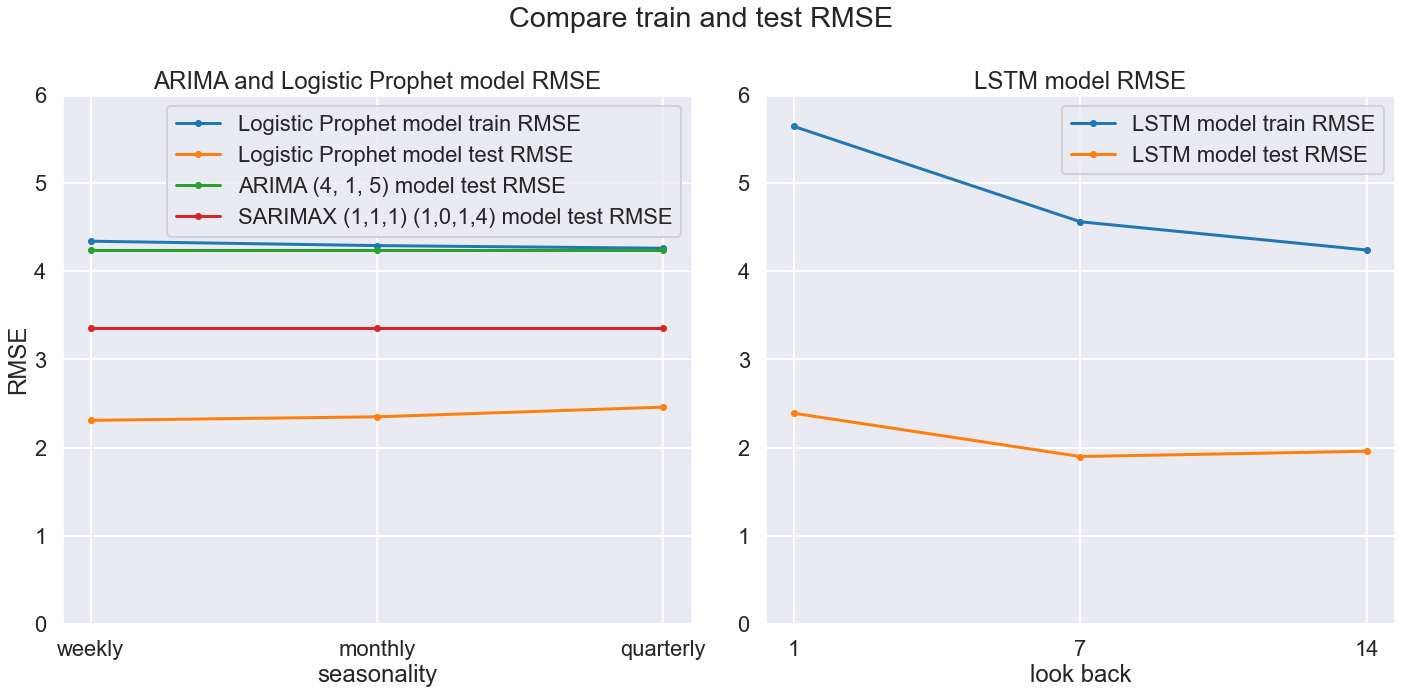

In [61]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(['weekly', 'monthly', 'quarterly'], log_proph_train_rmse_list, marker='.', label='Logistic Prophet model train RMSE')
ax[0].plot(['weekly', 'monthly', 'quarterly'], log_proph_test_rmse_list, marker='.', label='Logistic Prophet model test RMSE')
ax[0].plot(['weekly', 'monthly', 'quarterly'], [arima_rmse, arima_rmse, arima_rmse], marker='.', label='ARIMA (4, 1, 5) model test RMSE')
ax[0].plot(['weekly', 'monthly', 'quarterly'], [sarimax_rmse, sarimax_rmse, sarimax_rmse], marker='.', label='SARIMAX (1,1,1) (1,0,1,4) model test RMSE')
ax[0].legend()
ax[0].set_title('ARIMA and Logistic Prophet model RMSE')
ax[0].set_xlabel('seasonality')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim([0, 6])

ax[1].plot(['1', '7', '14'], lstm_train_rmse_list, marker='.', label='LSTM model train RMSE')
ax[1].plot(['1', '7', '14'], lstm_test_rmse_list, marker='.', label='LSTM model test RMSE')
ax[1].legend()
ax[1].set_title('LSTM model RMSE')
ax[1].set_xlabel('look back')
ax[1].set_ylabel('')
ax[1].set_ylim([0, 6])

fig.suptitle('Compare train and test RMSE')
fig.tight_layout()
plt.savefig('images/RMSE_comparison.jpeg', format='jpeg');

LSTM model with look_back=14 has the best train/test RMSE results. Let's fit our final model to it.

## Final Model (Prophet)

### Rename the columns for Weekly Logistic Prophet model

In [62]:
cat_data.reset_index(inplace=True)

In [63]:
# Prophet needs the date column to be named 'ds' and the target column to be named 'y' for it to run
cat_proph = cat_data.rename(columns={'sale_date': 'ds',
                                         'quantity': 'y'})
cat_proph.tail()

,ds,y
361,2020-12-27,2.0
362,2020-12-28,1.0
363,2020-12-29,2.0
364,2020-12-30,2.0
365,2020-12-31,3.0


In [65]:
# We need to specify a carrying capacity in order to utilize a saturating minimum later
cat_proph['cap'] = max_cap

# Let's specify a saturating minimum, so our model doesn't predict below it.
cat_proph['floor'] = 0

### Weekly Logistic Prophet model

In [158]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='weekly', period=7, fourier_order=3) # this line could be commented out
model_cat_proph.add_country_holidays(country_name='US')

In [159]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [160]:
# create test_dates variable that extends to 2021/03/31
test_dates = model_cat_proph.make_future_dataframe(periods=90, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [161]:
# predict up to 2020/03/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

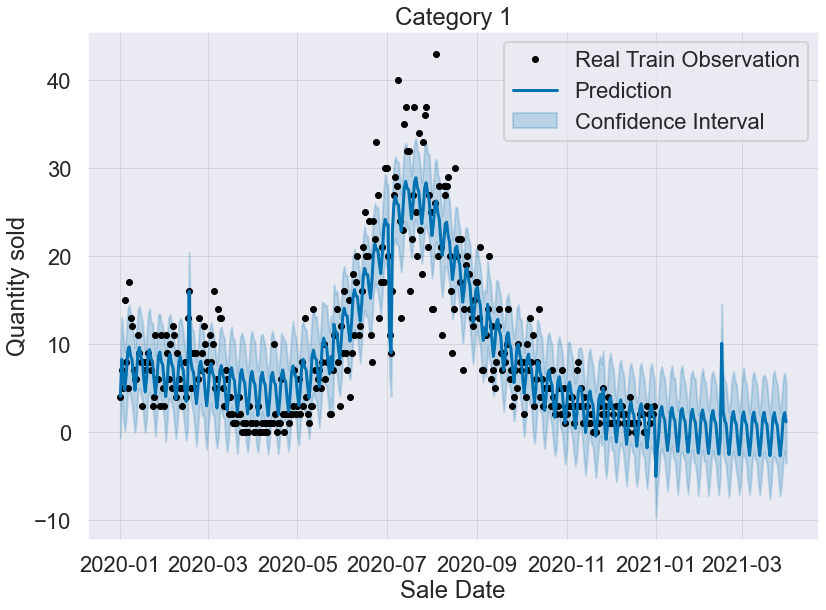

In [162]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
# ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold')
plt.legend(('Real Train Observation', 'Prediction', 'Confidence Interval'))
fig.tight_layout()
plt.savefig('images/log_prophet_wk_pred.jpeg', format='jpeg');

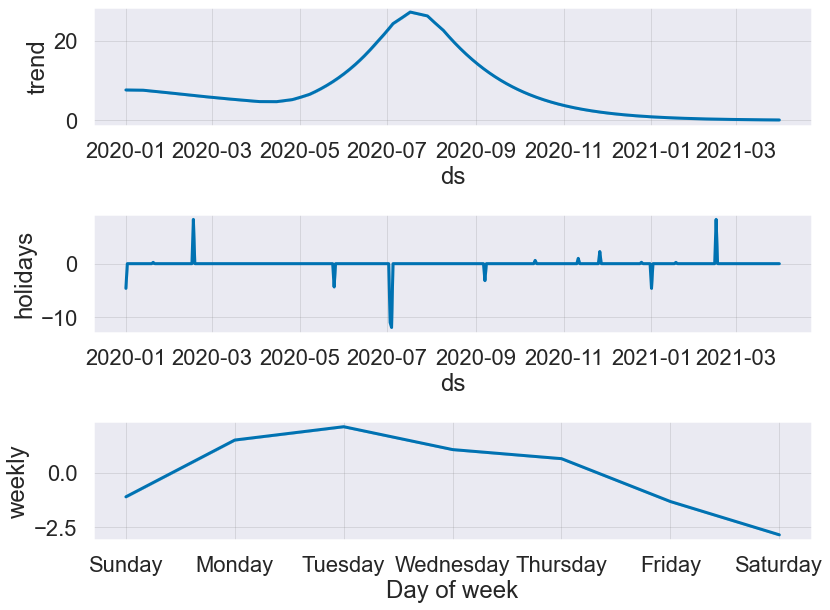

In [163]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_wk_components_pred.jpeg', format='jpeg');

### ( Exo) Weekly Logistic Prophet model

In [164]:
cat_API

,sale_date,unscaled,monthly,isPartial,scale,cat
date,,,,,,
2020-01-01,2020-01-01,36,0.0,0,0.00,0.00
2020-01-02,2020-01-02,100,0.0,0,0.00,0.00
2020-01-03,2020-01-03,78,0.0,0,0.00,0.00
2020-01-04,2020-01-04,87,0.0,0,0.00,0.00
2020-01-05,2020-01-05,54,82.0,False,0.82,44.28
...,...,...,...,...,...,...
2020-12-27,2020-12-27,86,56.0,False,0.56,48.16
2020-12-28,2020-12-28,93,56.0,0,0.56,52.08
2020-12-29,2020-12-29,78,56.0,0,0.56,43.68


In [165]:
cat_API.cat.values

array([  0.  ,   0.  ,   0.  ,   0.  ,  44.28,  56.58,  27.88,  54.12,
        38.54,  36.9 ,  40.18,  69.16,  59.15,  56.42,  60.97,  55.51,
        34.58,  50.05,  56.  , 100.  ,  64.  ,  46.  ,  67.  ,  83.  ,
        71.  ,  29.4 ,  35.  ,  35.  ,  32.2 ,  26.6 ,  32.2 ,  51.1 ,
        71.04,  62.9 ,  53.28,  40.7 ,  51.06,  56.98,  65.12,  54.78,
        56.76,  48.18,  45.54,  27.72,  37.62,  36.96,  52.7 ,  76.5 ,
        62.05,  62.05,  50.15,  74.8 ,  78.2 ,  73.15,  52.36,  50.05,
        43.12,  77.  ,  50.82,  50.05,  50.22,  43.4 ,  62.  ,  44.02,
        40.92,  24.8 ,  47.12,  42.4 ,  33.39,  32.86,  28.62,  32.86,
        18.02,  23.32,   9.36,   8.64,   7.44,   4.32,   5.76,   3.6 ,
         6.24,   4.32,   6.24,   5.04,   5.04,   3.6 ,   6.48,   4.8 ,
         6.21,   5.4 ,  11.88,  13.77,  14.58,  14.58,  11.88,  23.22,
        13.23,  17.82,  14.85,  19.98,   9.72,  11.88,  23.87,  10.85,
        26.04,  21.7 ,  18.29,  16.12,  25.11,  36.34,  46.  ,  39.56,
      

In [166]:
cat_proph['external'] = cat_API.cat.values

In [167]:
cat_proph.isna().sum()

ds          0
y           0
cap         0
floor       0
external    0
dtype: int64

In [168]:
cat_proph

,ds,y,cap,floor,external
0,2020-01-01,4.0,100,0,0.00
1,2020-01-02,7.0,100,0,0.00
2,2020-01-03,5.0,100,0,0.00
3,2020-01-04,15.0,100,0,0.00
4,2020-01-05,8.0,100,0,44.28
...,...,...,...,...,...
361,2020-12-27,2.0,100,0,48.16
362,2020-12-28,1.0,100,0,52.08
363,2020-12-29,2.0,100,0,43.68
364,2020-12-30,2.0,100,0,47.04


In [169]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='weekly', period=7, fourier_order=3) # this line could be commented out
model_cat_proph.add_country_holidays(country_name='US')
model_cat_proph.add_regressor('external')

In [170]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [171]:
# create test_dates variable that extends to 2021/03/31
test_dates = model_cat_proph.make_future_dataframe(periods=90, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [172]:
cat_API_external = list(cat_API.cat.values)
print(type(cat_API_external))
print(len(cat_API_external))

<class 'list'>
366


In [173]:
cat_API_external.extend(cat_API_external[:90])
len(cat_API_external)

456

In [174]:
test_dates['external'] = cat_API_external

In [175]:
test_dates

,ds,cap,floor,external
0,2020-01-01,100,0,0.00
1,2020-01-02,100,0,0.00
2,2020-01-03,100,0,0.00
3,2020-01-04,100,0,0.00
4,2020-01-05,100,0,44.28
...,...,...,...,...
451,2021-03-27,100,0,3.60
452,2021-03-28,100,0,6.48
453,2021-03-29,100,0,4.80
454,2021-03-30,100,0,6.21


In [176]:
# predict up to 2020/03/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

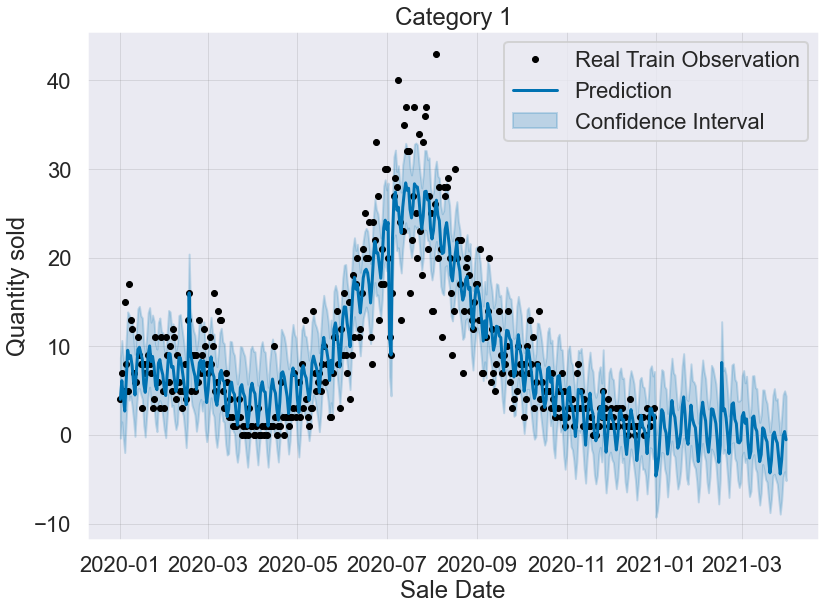

In [177]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
# ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold')
plt.legend(('Real Train Observation', 'Prediction', 'Confidence Interval'))
fig.tight_layout()
plt.savefig('images/log_prophet_wk_pred_exo.jpeg', format='jpeg');

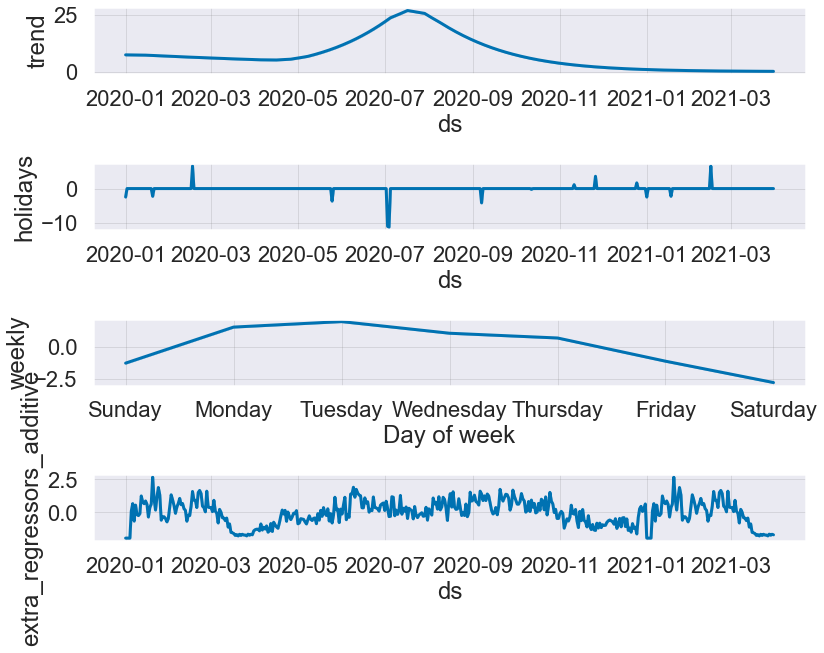

In [178]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_wk_components_pred_exo.jpeg', format='jpeg');

## Final Model (LSTM)

### Create LSTM dataset and scale it

In [91]:
# reset index in case index is equal to 'sale_date' column
cat_data.reset_index(inplace=True)

In [92]:
cat_data

,index,sale_date,quantity
0,0,2020-01-01,4.0
1,1,2020-01-02,7.0
2,2,2020-01-03,5.0
3,3,2020-01-04,15.0
4,4,2020-01-05,8.0
...,...,...,...
361,361,2020-12-27,2.0
362,362,2020-12-28,1.0
363,363,2020-12-29,2.0
364,364,2020-12-30,2.0


In [93]:
cat_data.sum()

index       66795.0
quantity     3399.0
dtype: float64

In [95]:
# drop column 'index' if it exists
cat_data.drop(['index'], axis=1, inplace=True)

In [96]:
cat_data

,sale_date,quantity
0,2020-01-01,4.0
1,2020-01-02,7.0
2,2020-01-03,5.0
3,2020-01-04,15.0
4,2020-01-05,8.0
...,...,...
361,2020-12-27,2.0
362,2020-12-28,1.0
363,2020-12-29,2.0
364,2020-12-30,2.0


In [97]:
pred_dates = pd.date_range(start='2020-01-01', end='2021-03-31')
type(pred_dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [98]:
pred_dates = pd.DataFrame(pred_dates)

In [99]:
pred_dates.columns = ['sale_date']

In [100]:
cat_data_pred = pd.merge(left=pred_dates, right=cat_data, on='sale_date', how='left')

In [101]:
cat_data_pred.isna().sum()

sale_date     0
quantity     90
dtype: int64

In [102]:
cat_data_pred.sum()

quantity    3399.0
dtype: float64

In [103]:
cat_data_pred.fillna(0, inplace=True)

In [104]:
cat_data_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  456 non-null    datetime64[ns]
 1   quantity   456 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 KB


In [105]:
cat_lstm = cat_data_pred
cat_lstm.set_index('sale_date', inplace=True)

In [106]:
cat_lstm.head()

,quantity
sale_date,
2020-01-01,4.0
2020-01-02,7.0
2020-01-03,5.0
2020-01-04,15.0
2020-01-05,8.0


In [107]:
cat_lstm.tail()

,quantity
sale_date,
2021-03-27,0.0
2021-03-28,0.0
2021-03-29,0.0
2021-03-30,0.0
2021-03-31,0.0


In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(cat_lstm)

### look_back = 14 (version 1)

In [179]:
look_back = 14

In [180]:
train = dataset[:round(len(dataset) * 366 / 456)]
test = dataset[round(len(dataset) * 366 / 456) - look_back:]
test.shape

(104, 1)

In [181]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [182]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [183]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [184]:
test_batch = testX[0]

In [185]:
testX.shape

(90, 1, 14)

In [186]:
test_batch[None].shape

(1, 1, 14)

In [189]:
for i in range(90):
    current_batch = test_batch[-14:]
    test_batch_add = model.predict(current_batch[None, None])
    test_batch = np.append(test_batch, test_batch_add)

In [190]:
len(test_batch)

105

In [191]:
test_batch = scaler.inverse_transform([test_batch])
test_batch

array([[0.        , 1.        , 1.        , 2.        , 2.        ,
        2.        , 0.        , 0.        , 3.        , 2.        ,
        1.        , 2.        , 2.        , 3.        , 2.09164341,
        2.11092534, 2.628922  , 2.33911785, 2.56275592, 2.55873297,
        2.46562047, 2.91505593, 2.61221909, 2.65176618, 2.78942633,
        2.71890155, 2.91490343, 2.84791879, 2.86435499, 2.9921154 ,
        2.89940369, 2.98946654, 3.01360519, 3.00864066, 3.11160149,
        3.07593574, 3.10970999, 3.15228462, 3.13743781, 3.1981117 ,
        3.20446762, 3.22312369, 3.26595558, 3.25845208, 3.29127738,
        3.30949294, 3.31876555, 3.35413911, 3.36058826, 3.38064021,
        3.40169621, 3.40817836, 3.4322193 , 3.44471136, 3.4591167 ,
        3.47951113, 3.48830093, 3.50523083, 3.51883491, 3.52968665,
        3.54664378, 3.5573632 , 3.570686  , 3.58420678, 3.59396765,
        3.60737566, 3.61818992, 3.62912143, 3.64149079, 3.6511424 ,
        3.66231932, 3.67265622, 3.68206692, 3.69

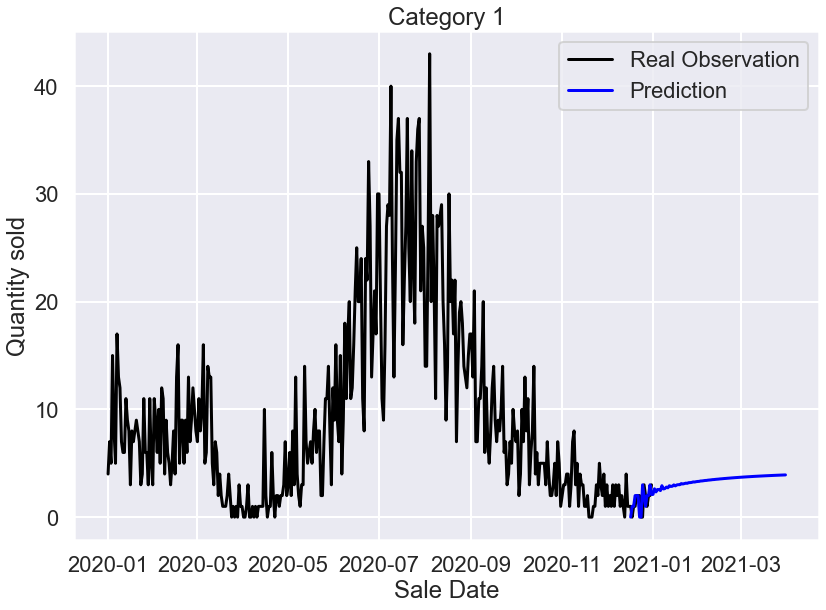

In [192]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_lstm.index[:366], scaler.inverse_transform(dataset)[:366], label='Real Observation', color='black')
ax.plot(cat_lstm.index[-105:], test_batch[0], label='Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity sold')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_14_pred_1.jpeg', format='jpeg');

### look_back = 14 (version 2)

In [193]:
look_back = 14

In [194]:
train = dataset[:round(len(dataset) * 366 / 456)]
test = dataset[round(len(dataset) * 366 / 456) - look_back:]
test.shape

(104, 1)

In [195]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [196]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [197]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [198]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(1, look_back))) # returns a sequence of vectors of dimension 32
model.add(LSTM(64))  # return a single vector of dimension 32
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opt)  # 'adam'

In [199]:
model.fit(trainX, trainY, epochs=300, verbose=0)  # was epochs=100, batch_size=3

In [200]:
test_batch = testX[0]

In [201]:
testX.shape

(90, 1, 14)

In [204]:
for i in range(90):
    current_batch = test_batch[-14:]
    test_batch_add = model.predict(current_batch[None, None])  # model.predict(current_batch[None, None])
    test_batch = np.append(test_batch, test_batch_add)

In [205]:
len(test_batch)

105

In [206]:
test_batch = scaler.inverse_transform([test_batch])
test_batch

array([[0.        , 1.        , 1.        , 2.        , 2.        ,
        2.        , 0.        , 0.        , 3.        , 2.        ,
        1.        , 2.        , 2.        , 3.        , 2.07158858,
        1.83921773, 2.36742715, 2.14198041, 2.38010663, 2.24092549,
        1.9738992 , 2.57458224, 2.13362871, 1.99492045, 2.21902274,
        2.00327503, 2.26102421, 2.0960577 , 1.96385449, 2.12593683,
        1.93728531, 1.99834974, 2.0058667 , 1.87038461, 2.03204358,
        1.89130093, 1.84886118, 1.91570774, 1.8000591 , 1.8725779 ,
        1.83819398, 1.77422022, 1.83429918, 1.75136435, 1.7607507 ,
        1.77065957, 1.7090489 , 1.75755367, 1.71334257, 1.69141739,
        1.71514019, 1.66458422, 1.68351646, 1.67473546, 1.6449973 ,
        1.66703653, 1.63492247, 1.63263691, 1.63743933, 1.61024735,
        1.62464484, 1.61016357, 1.59843016, 1.60720314, 1.58650228,
        1.59025515, 1.58760549, 1.57399163, 1.58151916, 1.56946345,
        1.566203  , 1.56816529, 1.55645094, 1.56

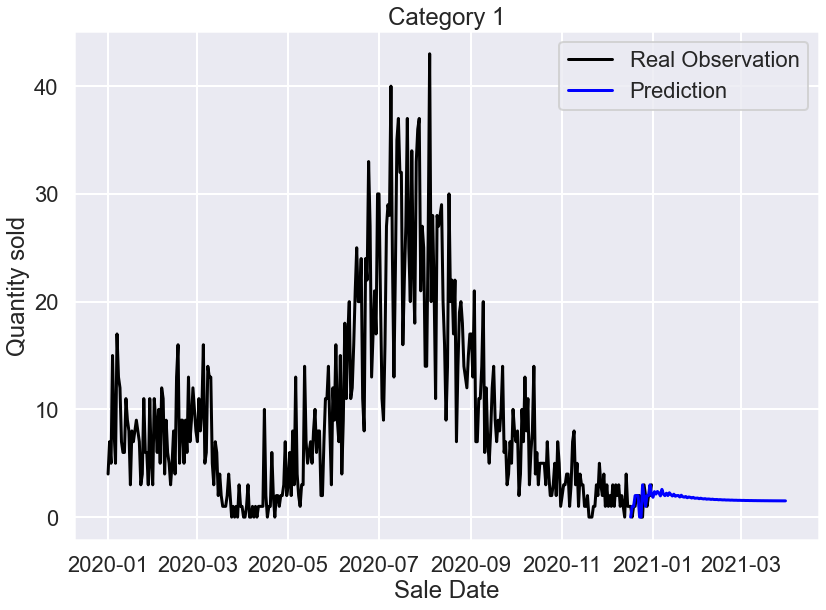

In [207]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_lstm.index[:366], scaler.inverse_transform(dataset)[:366], label='Real Observation', color='black')
ax.plot(cat_lstm.index[-105:], test_batch[0], label='Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity sold')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_14_pred_2.jpeg', format='jpeg');

### look_back = 14 (version 3)

In [208]:
look_back = 14

In [209]:
train = dataset[:round(len(dataset) * 366 / 456)]
test = dataset[round(len(dataset) * 366 / 456) - look_back:]
test.shape

(104, 1)

In [210]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [211]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [212]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [213]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(1, look_back))) # returns a sequence of vectors of dimension 32
model.add(LSTM(4))  # return a single vector of dimension 32
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opt)  # 'adam'

In [214]:
model.fit(trainX, trainY, epochs=300, verbose=2)  # was epochs=100, batch_size=3

Epoch 1/300
11/11 - 0s - loss: 0.0696
Epoch 2/300
11/11 - 0s - loss: 0.0402
Epoch 3/300
11/11 - 0s - loss: 0.0220
Epoch 4/300
11/11 - 0s - loss: 0.0151
Epoch 5/300
11/11 - 0s - loss: 0.0142
Epoch 6/300
11/11 - 0s - loss: 0.0131
Epoch 7/300
11/11 - 0s - loss: 0.0123
Epoch 8/300
11/11 - 0s - loss: 0.0118
Epoch 9/300
11/11 - 0s - loss: 0.0114
Epoch 10/300
11/11 - 0s - loss: 0.0111
Epoch 11/300
11/11 - 0s - loss: 0.0109
Epoch 12/300
11/11 - 0s - loss: 0.0108
Epoch 13/300
11/11 - 0s - loss: 0.0106
Epoch 14/300
11/11 - 0s - loss: 0.0106
Epoch 15/300
11/11 - 0s - loss: 0.0105
Epoch 16/300
11/11 - 0s - loss: 0.0102
Epoch 17/300
11/11 - 0s - loss: 0.0101
Epoch 18/300
11/11 - 0s - loss: 0.0102
Epoch 19/300
11/11 - 0s - loss: 0.0098
Epoch 20/300
11/11 - 0s - loss: 0.0098
Epoch 21/300
11/11 - 0s - loss: 0.0098
Epoch 22/300
11/11 - 0s - loss: 0.0095
Epoch 23/300
11/11 - 0s - loss: 0.0095
Epoch 24/300
11/11 - 0s - loss: 0.0095
Epoch 25/300
11/11 - 0s - loss: 0.0093
Epoch 26/300
11/11 - 0s - loss: 0.

Epoch 209/300
11/11 - 0s - loss: 0.0079
Epoch 210/300
11/11 - 0s - loss: 0.0079
Epoch 211/300
11/11 - 0s - loss: 0.0079
Epoch 212/300
11/11 - 0s - loss: 0.0079
Epoch 213/300
11/11 - 0s - loss: 0.0079
Epoch 214/300
11/11 - 0s - loss: 0.0079
Epoch 215/300
11/11 - 0s - loss: 0.0081
Epoch 216/300
11/11 - 0s - loss: 0.0079
Epoch 217/300
11/11 - 0s - loss: 0.0081
Epoch 218/300
11/11 - 0s - loss: 0.0079
Epoch 219/300
11/11 - 0s - loss: 0.0079
Epoch 220/300
11/11 - 0s - loss: 0.0079
Epoch 221/300
11/11 - 0s - loss: 0.0079
Epoch 222/300
11/11 - 0s - loss: 0.0079
Epoch 223/300
11/11 - 0s - loss: 0.0080
Epoch 224/300
11/11 - 0s - loss: 0.0079
Epoch 225/300
11/11 - 0s - loss: 0.0079
Epoch 226/300
11/11 - 0s - loss: 0.0079
Epoch 227/300
11/11 - 0s - loss: 0.0079
Epoch 228/300
11/11 - 0s - loss: 0.0078
Epoch 229/300
11/11 - 0s - loss: 0.0079
Epoch 230/300
11/11 - 0s - loss: 0.0078
Epoch 231/300
11/11 - 0s - loss: 0.0080
Epoch 232/300
11/11 - 0s - loss: 0.0078
Epoch 233/300
11/11 - 0s - loss: 0.0078


In [215]:
test_batch = testX[0]

In [216]:
testX.shape

(90, 1, 14)

In [219]:
for i in range(90):
    current_batch = test_batch[-14:]
    test_batch_add = model.predict(current_batch[None, None])  # model.predict(current_batch[None, None])
    test_batch = np.append(test_batch, test_batch_add)

In [220]:
len(test_batch)

105

In [221]:
test_batch = scaler.inverse_transform([test_batch])
test_batch

array([[0.        , 1.        , 1.        , 2.        , 2.        ,
        2.        , 0.        , 0.        , 3.        , 2.        ,
        1.        , 2.        , 2.        , 3.        , 2.40948661,
        2.2645525 , 2.78256166, 2.72203866, 2.94643666, 2.85915498,
        2.81547794, 3.42911647, 3.13461851, 3.1083798 , 3.33507712,
        3.24709863, 3.50183005, 3.44482189, 3.43197293, 3.61147646,
        3.54534722, 3.63137367, 3.65499235, 3.63896591, 3.79788151,
        3.74142791, 3.77061279, 3.8421836 , 3.81044405, 3.89043976,
        3.89332698, 3.89887907, 3.96463956, 3.94751936, 3.98380087,
        4.00413827, 4.00256074, 4.05262318, 4.04759553, 4.06528696,
        4.09398454, 4.08905237, 4.11864188, 4.12674385, 4.13367003,
        4.15951981, 4.15951116, 4.17596658, 4.18828499, 4.19158325,
        4.21065646, 4.21449519, 4.22405934, 4.23726744, 4.2396725 ,
        4.25236319, 4.25884245, 4.26428338, 4.27562946, 4.27904113,
        4.28723472, 4.29438902, 4.29818001, 4.30

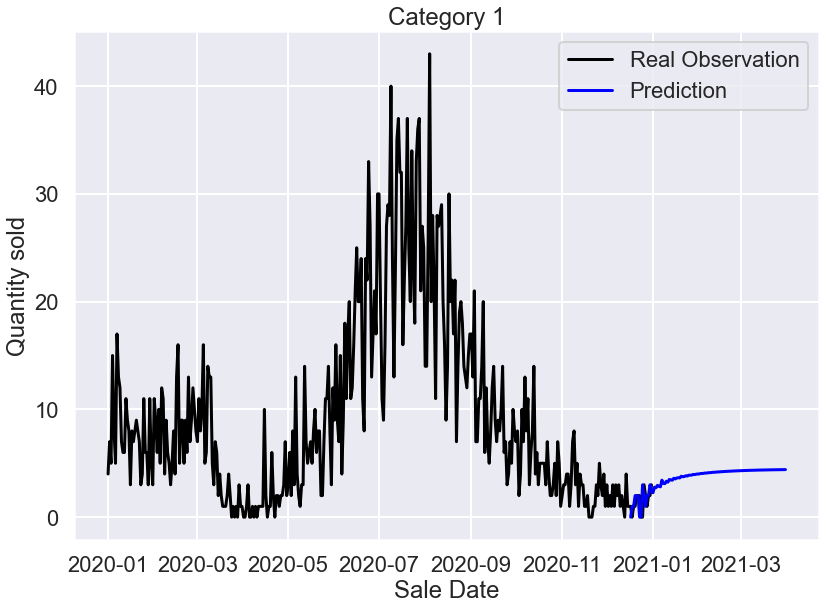

In [222]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_lstm.index[:366], scaler.inverse_transform(dataset)[:366], label='Real Observation', color='black')
ax.plot(cat_lstm.index[-105:], test_batch[0], label='Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity sold')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_14_pred_3.jpeg', format='jpeg');

## Conclusion

This space will be used to add conclusions.